# Time series-Prophet and GBMs

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [2]:
pd.read_csv('train.csv').head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
train = pd.read_csv("train.csv",parse_dates=True
                    ,low_memory=False,index_col="Date")
store = pd.read_csv("store.csv")

In [4]:
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

# Exploratory data analysis

In [5]:
print("In Total:",train.shape)
train.head()

In Total: (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [6]:
train["Year"] = train.index.year
train["Month"] = train.index.month
train["Day"] = train.index.day
train["week_of_the_year"] = train.index.weekofyear

In [7]:
train.sample()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,week_of_the_year
Date,,,,,,,,,,,,
2013-08-03,256,6,9962,1305,1,0,0,0,2013,8,3,31


In [8]:
train["sales_per_customer"] = train["Sales"]/train["Customers"]

In [9]:
train.sample()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,week_of_the_year,sales_per_customer
Date,,,,,,,,,,,,,
2013-10-08,44,2,6980,743,1,1,0,1,2013,10,8,41,9.394347


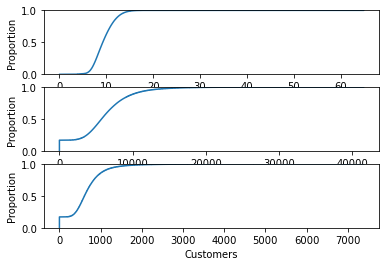

In [10]:
plt.subplot(311)
sns.ecdfplot(data=train, x="sales_per_customer");

plt.subplot(312)
sns.ecdfplot(data=train, x="Sales");

plt.subplot(313)
sns.ecdfplot(data=train, x="Customers");

In [11]:
#Missing values

In [12]:
train.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day',
       'week_of_the_year', 'sales_per_customer'],
      dtype='object')

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Store               1017209 non-null  int64  
 1   DayOfWeek           1017209 non-null  int64  
 2   Sales               1017209 non-null  int64  
 3   Customers           1017209 non-null  int64  
 4   Open                1017209 non-null  int64  
 5   Promo               1017209 non-null  int64  
 6   StateHoliday        1017209 non-null  object 
 7   SchoolHoliday       1017209 non-null  int64  
 8   Year                1017209 non-null  int64  
 9   Month               1017209 non-null  int64  
 10  Day                 1017209 non-null  int64  
 11  week_of_the_year    1017209 non-null  int64  
 12  sales_per_customer  844340 non-null   float64
dtypes: float64(1), int64(11), object(1)
memory usage: 108.6+ MB


In [14]:
train.isna().sum()

Store                      0
DayOfWeek                  0
Sales                      0
Customers                  0
Open                       0
Promo                      0
StateHoliday               0
SchoolHoliday              0
Year                       0
Month                      0
Day                        0
week_of_the_year           0
sales_per_customer    172869
dtype: int64

In [15]:
#Closed stores
Closed_store=train[(train.Open==0)&(train.Sales==0)].head()

In [16]:
Closed_store.shape

(5, 13)

In [17]:
#Open stores
Zero_sales=train[(train.Open!=0)&(train.Sales==0)]

In [18]:
Zero_sales.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,week_of_the_year,sales_per_customer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


In [19]:
train["Open"].unique()

array([1, 0], dtype=int64)

In [20]:
Zero_sales.shape

(54, 13)

In [21]:
#we are not taking the closed store on the data

In [22]:
train=train[(train['Open']!=0)&(train["Sales"]!=0)]

In [23]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,week_of_the_year,sales_per_customer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [24]:
train.shape

(844338, 13)

In [25]:
train.isna().sum()

Store                 0
DayOfWeek             0
Sales                 0
Customers             0
Open                  0
Promo                 0
StateHoliday          0
SchoolHoliday         0
Year                  0
Month                 0
Day                   0
week_of_the_year      0
sales_per_customer    0
dtype: int64

In [26]:
#Test

In [27]:
test=pd.read_csv("test.csv")

In [28]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [29]:
test.isna().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [30]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [31]:
test.isna().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [32]:
test

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [33]:
test.fillna(1, inplace = True)

In [34]:
test.sample()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
40673,40674,571,6,2015-08-01,1.0,0,0,0


In [35]:
test.isna().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [36]:
train_store=pd.merge(train,store,how="inner",on="Store")

In [37]:
train_store

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,sales_per_customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,292,1,9291,1002,1,1,0,0,2013,1,...,9.272455,a,a,1100.0,6.0,2009.0,0,NaN,NaN,NaN
844334,292,6,2748,340,1,0,0,0,2013,1,...,8.082353,a,a,1100.0,6.0,2009.0,0,NaN,NaN,NaN
844335,292,5,4202,560,1,0,0,1,2013,1,...,7.503571,a,a,1100.0,6.0,2009.0,0,NaN,NaN,NaN
844336,292,4,4580,662,1,0,0,1,2013,1,...,6.918429,a,a,1100.0,6.0,2009.0,0,NaN,NaN,NaN


In [38]:
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  int64  
 2   Sales                      844338 non-null  int64  
 3   Customers                  844338 non-null  int64  
 4   Open                       844338 non-null  int64  
 5   Promo                      844338 non-null  int64  
 6   StateHoliday               844338 non-null  object 
 7   SchoolHoliday              844338 non-null  int64  
 8   Year                       844338 non-null  int64  
 9   Month                      844338 non-null  int64  
 10  Day                        844338 non-null  int64  
 11  week_of_the_year           844338 non-null  int64  
 12  sales_per_customer         844338 non-null  float64
 13  StoreType                  84

In [39]:
train_store.isna().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Year                              0
Month                             0
Day                               0
week_of_the_year                  0
sales_per_customer                0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

In [40]:
train_store.groupby("StoreType")["Sales"].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [41]:
train_store.groupby("StoreType")["Customers","Sales"].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


In [42]:
#Clearly Store type A has the highest number of customers

In [43]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,sales_per_customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [44]:
train_store['Promo'].nunique()

2

In [45]:
train_store["Promo"].unique()

array([1, 0], dtype=int64)

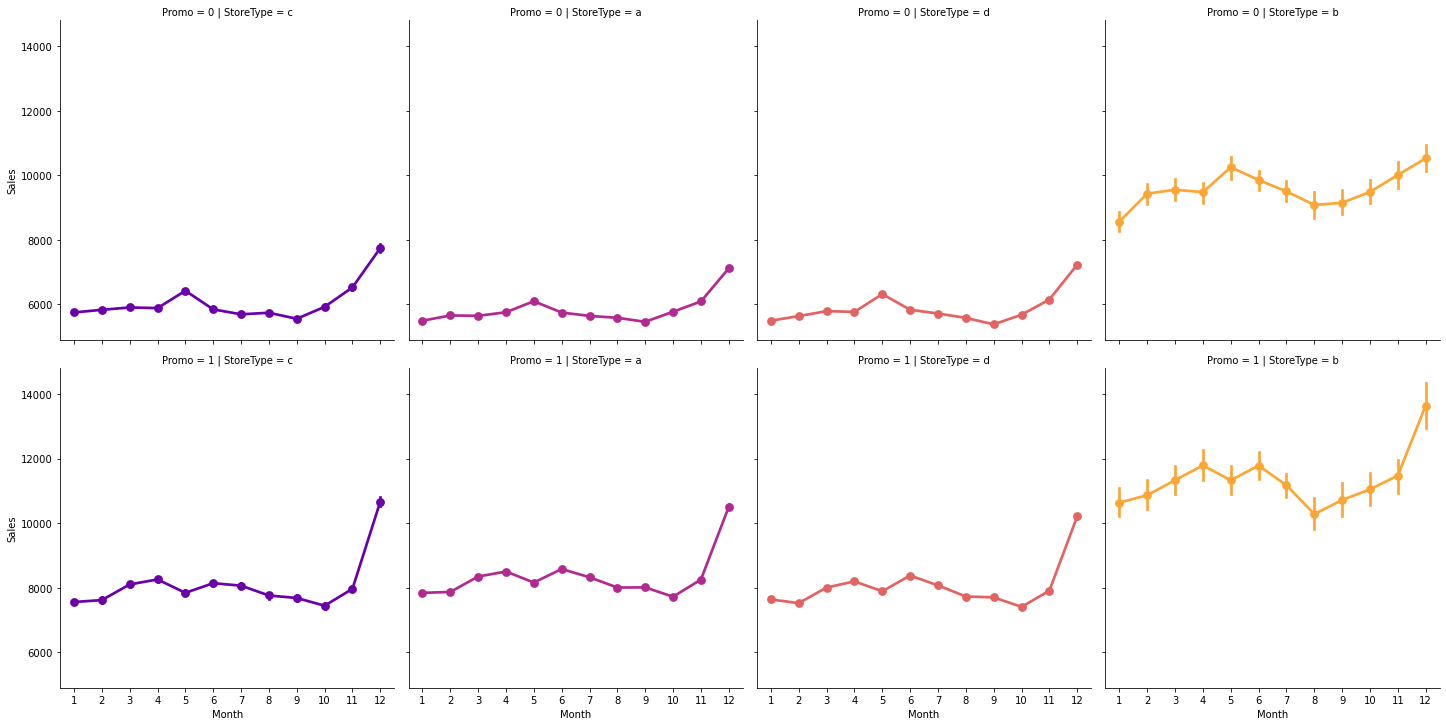

In [46]:
sns.factorplot(data=train_store,x='Month',y='Sales',
               hue="StoreType",col="StoreType",row="Promo",
               palette="plasma");

In [47]:
#whenever ther is promo there is increase in sales

In [48]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,sales_per_customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


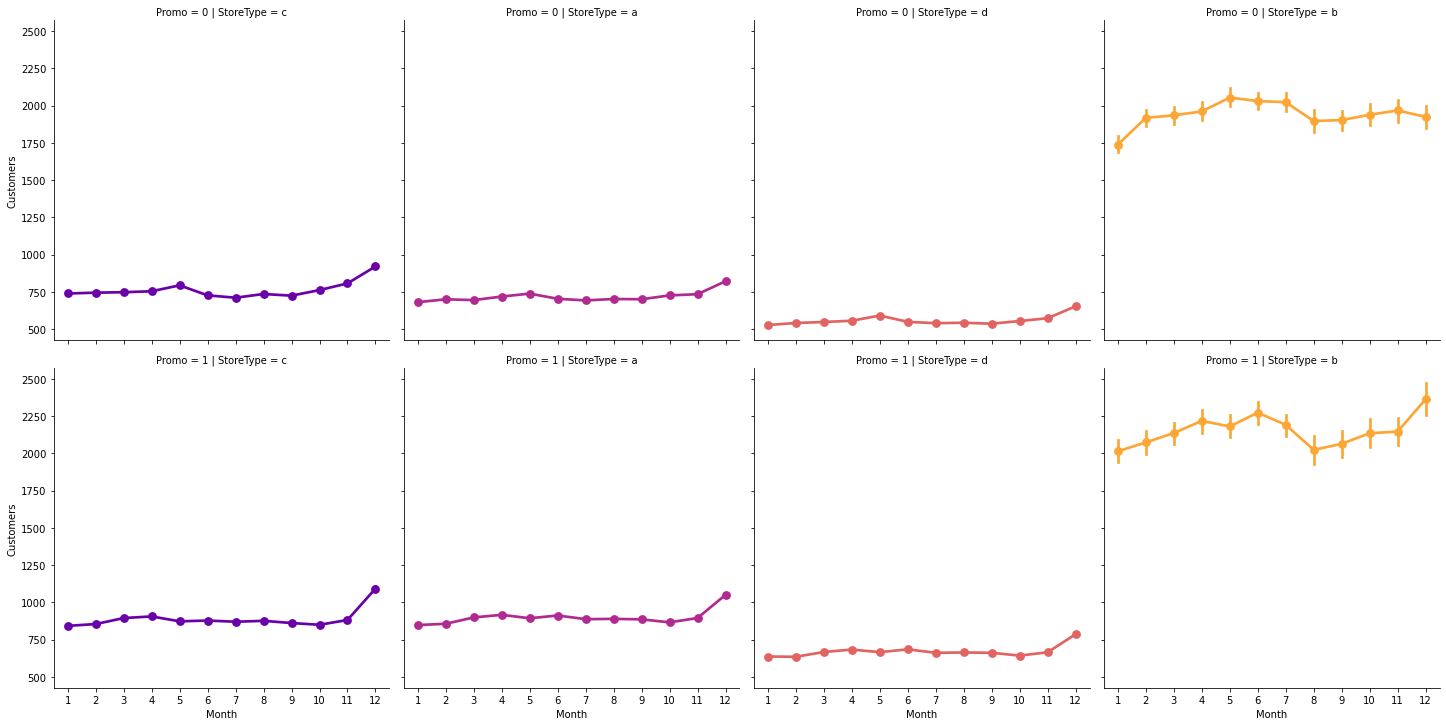

In [49]:
sns.factorplot(data=train_store,x="Month",y="Customers",
               hue="StoreType",col="StoreType",row="Promo",palette="plasma")

In [50]:
# From this above plot we conclude sales increases with respect to christmas

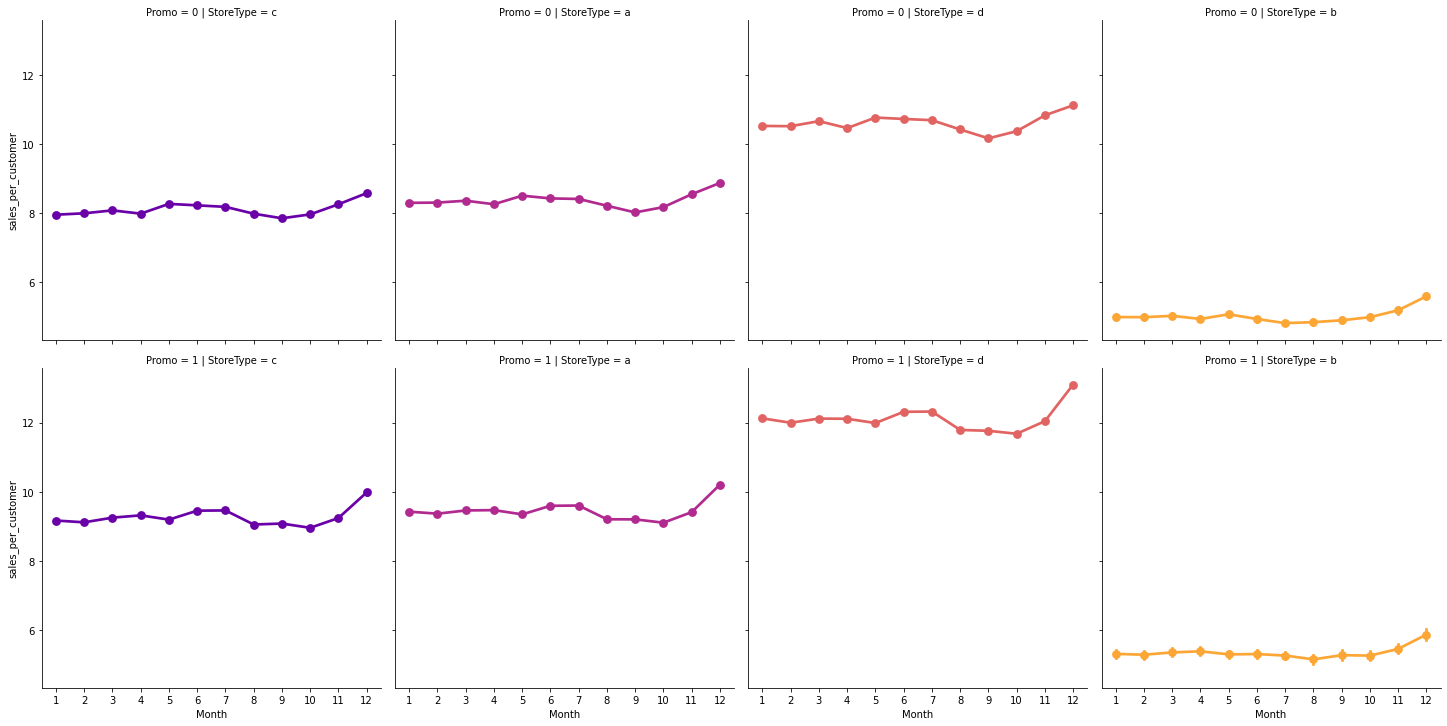

In [51]:
sns.factorplot(data=train_store,x="Month",y="sales_per_customer",
               hue="StoreType",col="StoreType",row="Promo",palette="plasma")

In [52]:
#Sales is higher in store type than other

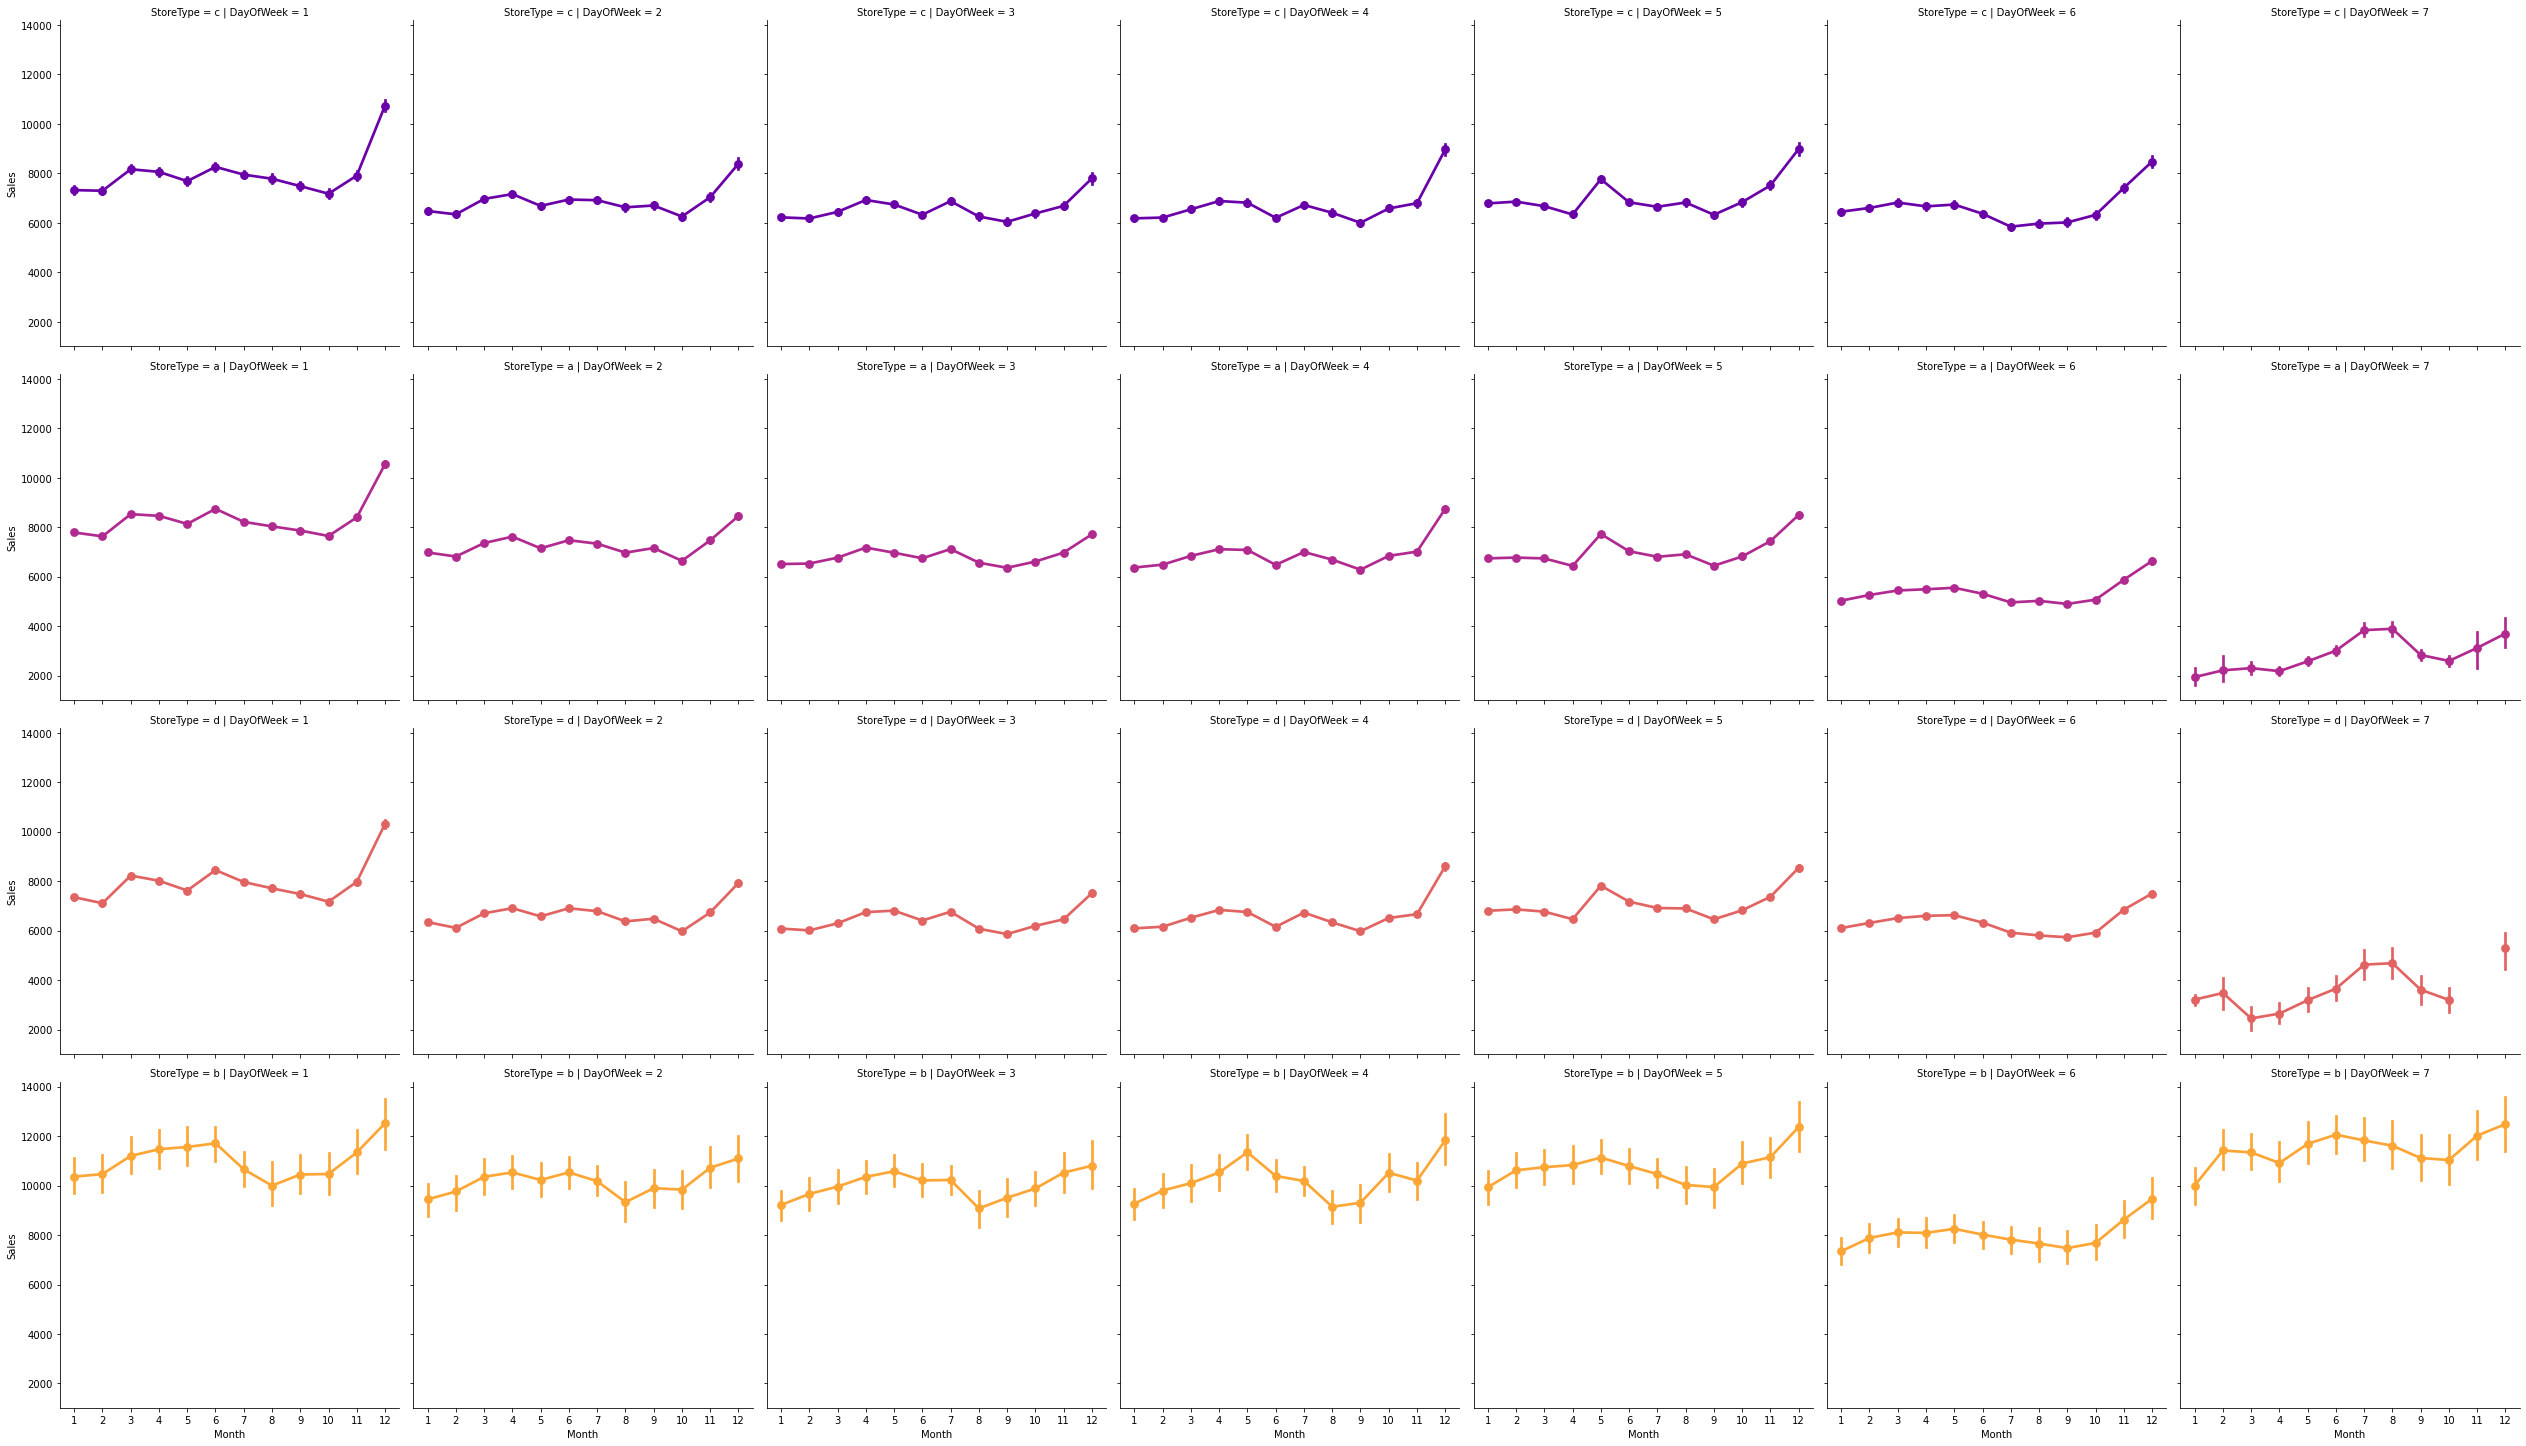

In [53]:
sns.factorplot(data=train_store,x="Month",y="Sales",
               hue="StoreType",col="DayOfWeek",row="StoreType",palette="plasma")

In [54]:
train_store[(train_store.Open==1)&(train_store.DayOfWeek==7)]["Store"].nunique()

33

In [55]:
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

In [56]:
train_store.isna().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Year                              0
Month                             0
Day                               0
week_of_the_year                  0
sales_per_customer                0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

In [57]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.week_of_the_year - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,10.958105,43.381276
b,10233.380141,2022.211825,3.717593,38.147815
c,6933.126425,815.538073,13.964386,45.339654
d,6822.300064,606.353935,14.827699,35.294751


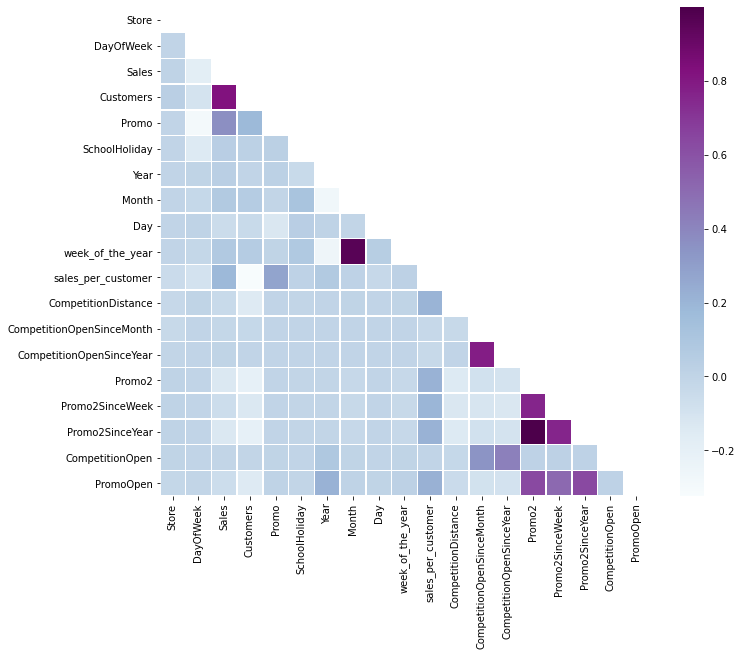

In [58]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

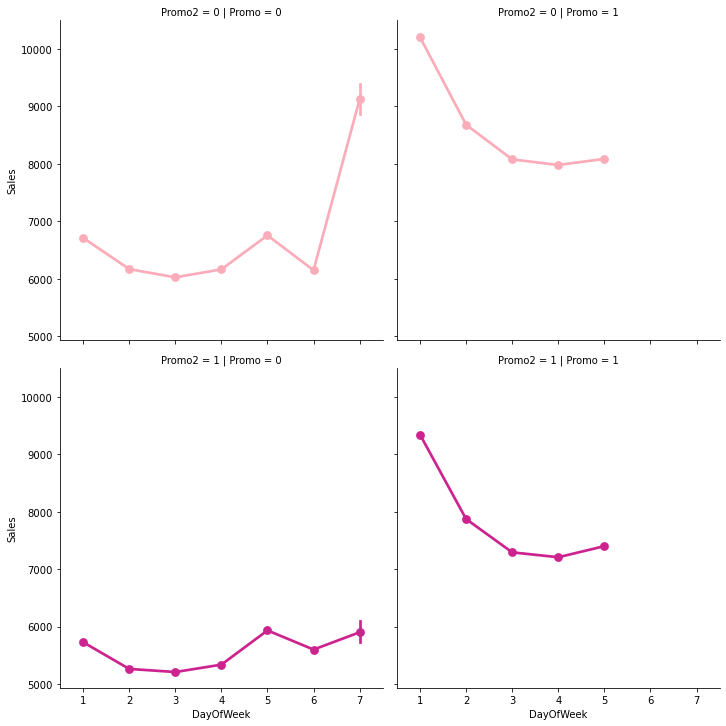

In [59]:
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

## Time-Series Analysis Per store

In [ ]:
# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

In [61]:
df=pd.read_csv("train.csv",low_memory=False)

In [62]:
df["Store"].nunique()

1115

In [63]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [64]:
df=df[(df["Open"]!=0)&(df["Sales"]!=0)]

In [66]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [68]:
df.Open.nunique()

1

In [69]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [74]:
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

In [75]:
sales

,Date,Sales
0,2015-07-31,5263
1115,2015-07-30,5020
2230,2015-07-29,4782
3345,2015-07-28,5011
4460,2015-07-27,6102
...,...,...
1009405,2013-01-07,7176
1011635,2013-01-05,4997
1012750,2013-01-04,4486
1013865,2013-01-03,4327


In [76]:
sales = sales.sort_index(ascending = False)

In [77]:
sales

,Date,Sales
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176
...,...,...
4460,2015-07-27,6102
3345,2015-07-28,5011
2230,2015-07-29,4782
1115,2015-07-30,5020


In [78]:
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [79]:
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


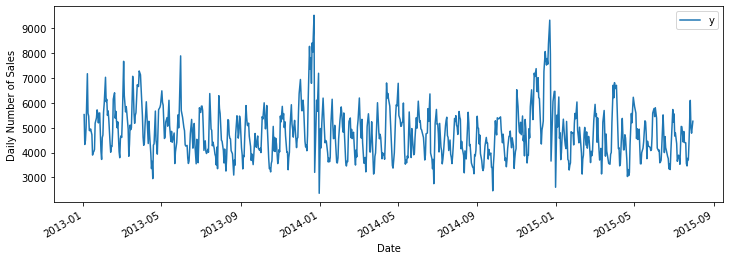

In [81]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [82]:
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04
